# 데이터 전처리

In [ ]:
!pip install pyproj
!pip install haversine
!pip install folium
!pip install selenium

     ---------------------------------------- 95.0/95.0 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import openpyxl
import os
import numpy as np
import unicodedata
from pyproj import Proj,transform#좌표변환
import pyproj
from haversine import haversine#위도,경도 거리계산
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
import matplotlib
import matplotlib.font_manager as fm
import folium
import webbrowser
from re import search
import time
import os, shutil
# 라이브러리 불러오기
from selenium import webdriver
from bs4 import BeautifulSoup
# 스크롤을 내리기 위해서 불러오기
from selenium.webdriver import ActionChains
from selenium.webdriver.common.keys import Keys

#창 안보여주기
options = webdriver.ChromeOptions()
options.add_argument("headless")
# 드라이버 연결
driver = webdriver.Chrome("chromedriver.exe")
# 웹사이트 이동
driver.implicitly_wait(2)
# 페이지 가져오기(이동)
driver.get('https://tmacs.kotsa.or.kr/web/TG/TG300/TG3050/Tg3050.jsp?mid=S1830')

#서울선택
driver.find_element_by_xpath('//*[@id="sido"]/option[2]').click()
#조회 클릭
driver.find_element_by_xpath('//*[@id="content"]/div[2]/div[1]/div[2]/a').click()

#스크롤 내리기
driver.execute_script("window.scrollTo(0, 380)")
#데이터 로딩 기다리기
time.sleep(5)
html = driver.page_source
soup= BeautifulSoup(html, "html.parser")
#리스트에 이름을 넣기
spot_list = soup.find_all("span", "rMateH5__DataGridItemRenderer rMateH5__DataGridColumn25")
#rMateH5__Content71 > span:nth-child(4)
time.sleep(5)

a=0
#총 데이터수
count=0
while(True):
    for i in range(len(spot_list)):
        j = (a+1)*2
        sopt = spot_list[a].get_text()
        #상세보기
        driver.find_element_by_xpath('//*[@id="rMateH5__Content71"]/div[%d]/span/img' %j).click()
        #time.sleep(3) #데이터 로딩 기다리기
        #창 전환
        driver.switch_to.window(driver.window_handles[-1])
        driver.get_window_position(driver.window_handles[-1])

        #세부조회
        driver.find_element_by_xpath('//*[@id="new_popup"]/div[2]/div[1]/ul/li[3]/a').click()
        time.sleep(15) #데이터 로딩 기다리기
        #엑셀 다운로드
        driver.find_element_by_xpath('//*[@id="new_popup"]/div[2]/div[3]/a[2]').click()
        time.sleep(4)
        
        driver.close()

        #파일 이름 바꾸기
    
        filepath = 'C:\\Users\\kim sang soo\\Downloads'#여기는 다운로드 경로를 입력
        filename = max([filepath + '\\' + f for f in os.listdir(filepath)], key=os.path.getctime)
        shutil.move(os.path.join(filepath, filename), sopt+'.xls') #리스트에 이름을 파일 이름으로 넣는다.
        
        #원래 창으로
        driver.switch_to.window(driver.window_handles[0])
        driver.get_window_position(driver.window_handles[0])

        if(a==13):
            #스크롤 내리기

            scroll = driver.find_element_by_xpath('//*[@id="grid1"]/div/div/div[2]')
 
            # ActionChains생성
            action = ActionChains(driver)
 
            # 클릭하고 잡기
            action.click_and_hold(scroll).perform()
 
            # 마우스 내리기
            for i in range(21):
                action.send_keys(Keys.ARROW_DOWN)
 
            # 마우스 놓아주기
            action.release(scroll).perform()
            html = driver.page_source
            soup= BeautifulSoup(html, "html.parser")
            spot_list = soup.find_all("span", "rMateH5__DataGridItemRenderer rMateH5__DataGridColumn25")
            a=-1
        a+=1
        count+=1    
    if(count>699):
        break

# 브라우저 (드라이버) 종료
driver.close()




In [ ]:
matplotlib.rcParams['axes.unicode_minus'] = False
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/Malgunsl.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)



In [ ]:
files = os.listdir("data")
df = pd.DataFrame([])

#데이터 불러오기
for j in files:
    data = pd.read_excel("data/"+j, header = [1])
    data.rename(columns = {"일련번호":"장소"}, inplace = True)
    data.loc[1:,"총 교통사고 수"] = len(data)-1
    uni2 = unicodedata.normalize('NFC',str(j.strip(".xls")))
    data.loc[1:,"장소"] = uni2
    df= pd.concat([df,data])
    
for i in range(len(df.columns)):
    if df.iloc[0,i] == df.iloc[0,i]:
        df.rename(columns = {df.columns[i]:df.iloc[0,i]}, inplace = True)

display(df)
#위도, 경도 넣기
spot = pd.read_csv("spot.csv", encoding = "cp949")
spot.rename(columns = {"장소2":"주소"}, inplace = True)
df = pd.merge(df, spot, left_on="장소",right_on = "장소", how = "inner")
display(df)

#필요없는 행 전처리
df.drop(labels = 0, axis = 0,inplace = True)
display(df)
df.drop(labels = 'ACC_NO', axis = 1,inplace = True)
display(df)
df.reset_index(drop=True, inplace = True)
display(df)

#필요없는  컬럼 전처리 후 컬럼 이름 변경
df.drop(labels = '사고유형1', axis = 1,inplace = True)
df.rename(columns = {"관련자2":"관련자"}, inplace = True)
df.rename(columns = {"사고유형2":"사고유형"}, inplace = True)

#날짜 형식 맞추기
df['년도'] = df['년도'].astype(int)
df['월'] = df['월'].astype(int)
df['일'] = df['일'].astype(int)
df['년도'] = df['년도'].astype(str)
df['월'] = df['월'].astype(str)
df['일'] = df['일'].astype(str)
df['시각'] = df['시각'].astype(int)
df['시각'] = df['시각'].astype(str)
for i in range(len(df)):
  year = int(df.loc[i,'년도'])
  month = int(str(df.loc[i,'월']).zfill(2))
  day = int(str(df.loc[i,'일']).zfill(2))
  hour = int(str(df.loc[i,'시각']).zfill(2))
  df.loc[i,'날짜'] = pd.Timestamp(year, month, day, hour,0,0)

df.drop(labels = '년도', axis = 1,inplace = True)
df.drop(labels = '월', axis = 1,inplace = True)
df.drop(labels = '일', axis = 1,inplace = True)
df.drop(labels = '시각', axis = 1,inplace = True)


df['음주'].replace('0', 1, inplace = True)
df['음주'].fillna(0, inplace = True)
df["연령"].replace("불명", np.NaN, inplace = True)
df['연령'] = pd.to_numeric(df['연령'])
df['음주'] = pd.to_numeric(df['음주'])



display(df)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace = True)
display(df)


df.to_csv("all_data.csv", index = False, encoding = "cp949")

,장소,년도,월,일,요일,시각,사고등급,사망자수,중상자수,경상자수,...,관련자2,사고형태,기상상태,일광상태,사고유형1,사고유형2,법규위반,도로종류,ACC_NO,총 교통사고 수
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CGV(강남역점 앞 삼거리),2018.0,1.0,15.0,월요일,1.0,중상사고,0.0,1.0,0.0,...,승용,일직선사고,맑음,심야,차대차,추돌(진행중),차로위반,특별광역시도,NaN,16.0
2,CGV(강남역점 앞 삼거리),2018.0,1.0,12.0,금요일,13.0,중상사고,0.0,1.0,0.0,...,보행자,진입회전사고,맑음,주간,차대사람,횡단중,신호위반,특별광역시도,NaN,16.0
3,CGV(강남역점 앞 삼거리),2018.0,1.0,11.0,목요일,23.0,중상사고,0.0,1.0,0.0,...,보행자,보행횡단사고,맑음,심야,차대사람,횡단중,안전운전불이행,특별광역시도,NaN,16.0
4,CGV(강남역점 앞 삼거리),2018.0,5.0,17.0,목요일,0.0,중상사고,0.0,1.0,0.0,...,보행자,기타사고,비,심야,차대사람,차대사람-기타,안전운전불이행,특별광역시도,NaN,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,흥인시장 앞 삼거리,2020.0,3.0,17.0,화요일,13.0,중상사고,0.0,1.0,0.0,...,승합,기타사고,맑음,주간,차대차,차대차-기타,안전거리미확보,특별광역시도,NaN,10.0
7,흥인시장 앞 삼거리,2020.0,4.0,6.0,월요일,19.0,중상사고,0.0,1.0,0.0,...,화물,진입회전사고,맑음,출퇴근,차대차,측면직각충돌,안전운전불이행,특별광역시도,NaN,10.0
8,흥인시장 앞 삼거리,2020.0,7.0,22.0,수요일,14.0,중상사고,0.0,1.0,0.0,...,원동기,진입회전사고,맑음,주간,차대차,측면직각충돌,신호위반,특별광역시도,NaN,10.0
9,흥인시장 앞 삼거리,2020.0,9.0,17.0,목요일,13.0,중상사고,0.0,1.0,0.0,...,이륜,진입회전사고,맑음,주간,차대차,측면직각충돌,안전운전불이행,특별광역시도,NaN,10.0


,장소,년도,월,일,요일,시각,사고등급,사망자수,중상자수,경상자수,...,일광상태,사고유형1,사고유형2,법규위반,도로종류,ACC_NO,총 교통사고 수,주소,경도,위도
0,CGV(강남역점 앞 삼거리),2018.0,1.0,15.0,월요일,1.0,중상사고,0.0,1.0,0.0,...,심야,차대차,추돌(진행중),차로위반,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
1,CGV(강남역점 앞 삼거리),2018.0,1.0,12.0,금요일,13.0,중상사고,0.0,1.0,0.0,...,주간,차대사람,횡단중,신호위반,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
2,CGV(강남역점 앞 삼거리),2018.0,1.0,11.0,목요일,23.0,중상사고,0.0,1.0,0.0,...,심야,차대사람,횡단중,안전운전불이행,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
3,CGV(강남역점 앞 삼거리),2018.0,5.0,17.0,목요일,0.0,중상사고,0.0,1.0,0.0,...,심야,차대사람,차대사람-기타,안전운전불이행,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
4,CGV(강남역점 앞 삼거리),2018.0,5.0,9.0,수요일,2.0,중상사고,0.0,1.0,0.0,...,심야,차대사람,횡단중,안전운전불이행,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,흥인시장 앞 삼거리,2020.0,3.0,17.0,화요일,13.0,중상사고,0.0,1.0,0.0,...,주간,차대차,차대차-기타,안전거리미확보,특별광역시도,NaN,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9116,흥인시장 앞 삼거리,2020.0,4.0,6.0,월요일,19.0,중상사고,0.0,1.0,0.0,...,출퇴근,차대차,측면직각충돌,안전운전불이행,특별광역시도,NaN,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9117,흥인시장 앞 삼거리,2020.0,7.0,22.0,수요일,14.0,중상사고,0.0,1.0,0.0,...,주간,차대차,측면직각충돌,신호위반,특별광역시도,NaN,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9118,흥인시장 앞 삼거리,2020.0,9.0,17.0,목요일,13.0,중상사고,0.0,1.0,0.0,...,주간,차대차,측면직각충돌,안전운전불이행,특별광역시도,NaN,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806


,장소,년도,월,일,요일,시각,사고등급,사망자수,중상자수,경상자수,...,일광상태,사고유형1,사고유형2,법규위반,도로종류,ACC_NO,총 교통사고 수,주소,경도,위도
1,CGV(강남역점 앞 삼거리),2018.0,1.0,12.0,금요일,13.0,중상사고,0.0,1.0,0.0,...,주간,차대사람,횡단중,신호위반,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
2,CGV(강남역점 앞 삼거리),2018.0,1.0,11.0,목요일,23.0,중상사고,0.0,1.0,0.0,...,심야,차대사람,횡단중,안전운전불이행,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
3,CGV(강남역점 앞 삼거리),2018.0,5.0,17.0,목요일,0.0,중상사고,0.0,1.0,0.0,...,심야,차대사람,차대사람-기타,안전운전불이행,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
4,CGV(강남역점 앞 삼거리),2018.0,5.0,9.0,수요일,2.0,중상사고,0.0,1.0,0.0,...,심야,차대사람,횡단중,안전운전불이행,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
5,CGV(강남역점 앞 삼거리),2018.0,7.0,25.0,수요일,20.0,중상사고,0.0,1.0,0.0,...,출퇴근,차대사람,횡단중,신호위반,특별광역시도,NaN,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,흥인시장 앞 삼거리,2020.0,3.0,17.0,화요일,13.0,중상사고,0.0,1.0,0.0,...,주간,차대차,차대차-기타,안전거리미확보,특별광역시도,NaN,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9116,흥인시장 앞 삼거리,2020.0,4.0,6.0,월요일,19.0,중상사고,0.0,1.0,0.0,...,출퇴근,차대차,측면직각충돌,안전운전불이행,특별광역시도,NaN,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9117,흥인시장 앞 삼거리,2020.0,7.0,22.0,수요일,14.0,중상사고,0.0,1.0,0.0,...,주간,차대차,측면직각충돌,신호위반,특별광역시도,NaN,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9118,흥인시장 앞 삼거리,2020.0,9.0,17.0,목요일,13.0,중상사고,0.0,1.0,0.0,...,주간,차대차,측면직각충돌,안전운전불이행,특별광역시도,NaN,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806


,장소,년도,월,일,요일,시각,사고등급,사망자수,중상자수,경상자수,...,기상상태,일광상태,사고유형1,사고유형2,법규위반,도로종류,총 교통사고 수,주소,경도,위도
1,CGV(강남역점 앞 삼거리),2018.0,1.0,12.0,금요일,13.0,중상사고,0.0,1.0,0.0,...,맑음,주간,차대사람,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
2,CGV(강남역점 앞 삼거리),2018.0,1.0,11.0,목요일,23.0,중상사고,0.0,1.0,0.0,...,맑음,심야,차대사람,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
3,CGV(강남역점 앞 삼거리),2018.0,5.0,17.0,목요일,0.0,중상사고,0.0,1.0,0.0,...,비,심야,차대사람,차대사람-기타,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
4,CGV(강남역점 앞 삼거리),2018.0,5.0,9.0,수요일,2.0,중상사고,0.0,1.0,0.0,...,맑음,심야,차대사람,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
5,CGV(강남역점 앞 삼거리),2018.0,7.0,25.0,수요일,20.0,중상사고,0.0,1.0,0.0,...,맑음,출퇴근,차대사람,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,흥인시장 앞 삼거리,2020.0,3.0,17.0,화요일,13.0,중상사고,0.0,1.0,0.0,...,맑음,주간,차대차,차대차-기타,안전거리미확보,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9116,흥인시장 앞 삼거리,2020.0,4.0,6.0,월요일,19.0,중상사고,0.0,1.0,0.0,...,맑음,출퇴근,차대차,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9117,흥인시장 앞 삼거리,2020.0,7.0,22.0,수요일,14.0,중상사고,0.0,1.0,0.0,...,맑음,주간,차대차,측면직각충돌,신호위반,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9118,흥인시장 앞 삼거리,2020.0,9.0,17.0,목요일,13.0,중상사고,0.0,1.0,0.0,...,맑음,주간,차대차,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806


,장소,년도,월,일,요일,시각,사고등급,사망자수,중상자수,경상자수,...,기상상태,일광상태,사고유형1,사고유형2,법규위반,도로종류,총 교통사고 수,주소,경도,위도
0,CGV(강남역점 앞 삼거리),2018.0,1.0,12.0,금요일,13.0,중상사고,0.0,1.0,0.0,...,맑음,주간,차대사람,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
1,CGV(강남역점 앞 삼거리),2018.0,1.0,11.0,목요일,23.0,중상사고,0.0,1.0,0.0,...,맑음,심야,차대사람,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
2,CGV(강남역점 앞 삼거리),2018.0,5.0,17.0,목요일,0.0,중상사고,0.0,1.0,0.0,...,비,심야,차대사람,차대사람-기타,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
3,CGV(강남역점 앞 삼거리),2018.0,5.0,9.0,수요일,2.0,중상사고,0.0,1.0,0.0,...,맑음,심야,차대사람,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
4,CGV(강남역점 앞 삼거리),2018.0,7.0,25.0,수요일,20.0,중상사고,0.0,1.0,0.0,...,맑음,출퇴근,차대사람,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9114,흥인시장 앞 삼거리,2020.0,3.0,17.0,화요일,13.0,중상사고,0.0,1.0,0.0,...,맑음,주간,차대차,차대차-기타,안전거리미확보,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9115,흥인시장 앞 삼거리,2020.0,4.0,6.0,월요일,19.0,중상사고,0.0,1.0,0.0,...,맑음,출퇴근,차대차,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9116,흥인시장 앞 삼거리,2020.0,7.0,22.0,수요일,14.0,중상사고,0.0,1.0,0.0,...,맑음,주간,차대차,측면직각충돌,신호위반,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806
9117,흥인시장 앞 삼거리,2020.0,9.0,17.0,목요일,13.0,중상사고,0.0,1.0,0.0,...,맑음,주간,차대차,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806


,장소,요일,사고등급,사망자수,중상자수,경상자수,부상자수,연령,성별,경력,...,기상상태,일광상태,사고유형,법규위반,도로종류,총 교통사고 수,주소,경도,위도,날짜
0,CGV(강남역점 앞 삼거리),금요일,중상사고,0.0,1.0,0.0,0.0,67.0,남,15년이상,...,맑음,주간,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-12 13:00:00
1,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,61.0,남,15년이상,...,맑음,심야,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-11 23:00:00
2,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,44.0,남,15년미만,...,비,심야,차대사람-기타,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-17 00:00:00
3,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,33.0,남,10년미만,...,맑음,심야,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-09 02:00:00
4,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,57.0,남,15년이상,...,맑음,출퇴근,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-07-25 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9114,흥인시장 앞 삼거리,화요일,중상사고,0.0,1.0,0.0,0.0,43.0,여,10년미만,...,맑음,주간,차대차-기타,안전거리미확보,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-03-17 13:00:00
9115,흥인시장 앞 삼거리,월요일,중상사고,0.0,1.0,0.0,0.0,32.0,남,10년미만,...,맑음,출퇴근,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-04-06 19:00:00
9116,흥인시장 앞 삼거리,수요일,중상사고,0.0,1.0,0.0,0.0,72.0,남,15년이상,...,맑음,주간,측면직각충돌,신호위반,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-07-22 14:00:00
9117,흥인시장 앞 삼거리,목요일,중상사고,0.0,1.0,0.0,0.0,47.0,남,15년이상,...,맑음,주간,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-09-17 13:00:00


,장소,요일,사고등급,사망자수,중상자수,경상자수,부상자수,연령,성별,경력,...,기상상태,일광상태,사고유형,법규위반,도로종류,총 교통사고 수,주소,경도,위도,날짜
0,CGV(강남역점 앞 삼거리),금요일,중상사고,0.0,1.0,0.0,0.0,67.0,남,15년이상,...,맑음,주간,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-12 13:00:00
1,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,61.0,남,15년이상,...,맑음,심야,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-11 23:00:00
2,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,44.0,남,15년미만,...,비,심야,차대사람-기타,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-17 00:00:00
3,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,33.0,남,10년미만,...,맑음,심야,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-09 02:00:00
4,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,57.0,남,15년이상,...,맑음,출퇴근,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-07-25 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,흥인시장 앞 삼거리,화요일,중상사고,0.0,1.0,0.0,0.0,43.0,여,10년미만,...,맑음,주간,차대차-기타,안전거리미확보,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-03-17 13:00:00
9004,흥인시장 앞 삼거리,월요일,중상사고,0.0,1.0,0.0,0.0,32.0,남,10년미만,...,맑음,출퇴근,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-04-06 19:00:00
9005,흥인시장 앞 삼거리,수요일,중상사고,0.0,1.0,0.0,0.0,72.0,남,15년이상,...,맑음,주간,측면직각충돌,신호위반,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-07-22 14:00:00
9006,흥인시장 앞 삼거리,목요일,중상사고,0.0,1.0,0.0,0.0,47.0,남,15년이상,...,맑음,주간,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-09-17 13:00:00


In [ ]:
#cctv 데이터

cctv1 = pd.read_csv("cctv1.csv", encoding = "cp949")
cctv2 = pd.read_csv("cctv2.csv", encoding = "cp949")
cctv2.rename(columns = {"XPOINT":"위도"}, inplace = True)
cctv2.rename(columns = {"YPOINT":"경도"}, inplace = True)
cctv = pd.concat([cctv1,cctv2])
cctv = cctv.loc[:,["위도","경도"]]
cctv.dropna(inplace=True)
cctv.reset_index(drop=True, inplace = True)


#x좌표,y좌표
epsg5186= Proj(init="EPSG:5186")
# 위도경도
proj_WGS84 = Proj(init='epsg:4326')




light = pd.read_csv("light.csv", encoding = "cp949")
light.dropna(inplace=True)
light.reset_index(drop=True, inplace = True)
light['경도'],light['위도'] = transform(epsg5186, proj_WGS84, light['X좌표'].tolist(), light['Y좌표'].tolist())


sign = pd.read_csv("sign.csv", encoding = "cp949")
sign.dropna(inplace=True)
sign.reset_index(drop=True, inplace = True)
sign['경도'],sign['위도'] = transform(epsg5186, proj_WGS84, sign['X좌표'].tolist(), sign['Y좌표'].tolist())


bump = pd.read_csv("bump.csv", encoding = "cp949")
bump.dropna(inplace=True)
bump.reset_index(drop=True, inplace = True)


display(cctv)
display(light)
display(sign)
display(bump)


C:\Users\SubinOh\anaconda3\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\SubinOh\anaconda3\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-55-207400de857e>:31: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  light['경도'],light['위도'] = transform

,위도,경도
0,37.535891,126.870566
1,37.532740,126.867191
2,37.524535,126.848224
3,37.522349,126.833529
4,37.528982,126.874597
...,...,...
4402,126.979720,37.534720
4403,127.005560,37.536110
4404,126.976940,37.560560
4405,127.115800,37.522570


,지주관리번호,X좌표,Y좌표,경도,위도
0,02-0000150555,192953.5446,554142.4798,126.920219,37.586815
1,02-0000150555,192953.5446,554142.4798,126.920219,37.586815
2,02-0000150555,192953.5446,554142.4798,126.920219,37.586815
3,02-0000085140,206952.3838,557671.2727,127.078749,37.618609
4,02-0000180600,207978.0625,540434.5000,127.090179,37.463298
...,...,...,...,...,...
113601,02-0000167399,191911.2777,555237.4118,126.908407,37.596671
113602,02-0000085989,201196.5390,562034.1272,127.013560,37.657944
113603,02-0000085989,201194.9538,562020.4231,127.013542,37.657820
113604,02-0000103074,201204.0150,562042.1911,127.013645,37.658016


,비고,X좌표,Y좌표,경도,위도
0,기타,197430.8267,551261.0486,126.970922,37.560876
1,T형설치,198212.5783,553261.4256,126.979765,37.578902
2,기타,200019.7131,554940.8585,127.000223,37.594035
3,기타,199996.2121,554853.2548,126.999957,37.593246
4,기타,199994.2174,554963.7727,126.999935,37.594241
...,...,...,...,...,...
349995,기타,200206.0916,549129.2568,127.002332,37.541673
349996,기타,199043.0000,551338.7813,126.989168,37.561580
349997,기타,198998.5931,551529.4667,126.988666,37.563298
349998,기타,198959.1780,551573.5498,126.988219,37.563695


,소재지도로명주소,위도,경도
0,서울특별시 관악구 장군봉1길20,37.481806,126.941212
1,서울특별시 관악구 장군봉길69,37.479898,126.938894
2,서울특별시 관악구 장군봉길93,37.479102,126.939491
3,서울특별시 관악구 쑥고개로21,37.478179,126.939289
4,서울특별시 관악구 참숯5길 18,37.476752,126.940655
...,...,...,...
25069,북촌로 141,37.587191,126.982673
25070,"서울특별시 강서구 마곡서로 133(마곡동, 마곡엠밸리7단지)",38.280600,126.492300
25071,"서울특별시 강서구 강서로18마길 15(화곡동, 호성주택)",38.262000,126.505000
25072,"서울특별시 강서구 마곡서로 133(마곡동, 마곡엠밸리7단지)",38.281000,126.492300


In [ ]:
#신호등, 안전표지판, 씨씨티비 데이터 추가
def add_data(data, col):
  df[col] = 0
  for i in range(len(df)):
    spot = (df.loc[i, "위도"], df.loc[i, "경도"])
    count = 0
    for j in range(len(data)):
      spot_ =  (data.loc[j, "위도"],data.loc[j, "경도"])
      dist = haversine(spot, spot_)
      if dist < 1: #반경 1km 이내에 있는 해당 데이터 개수
        count += 1
    df.loc[i,col] = count


  return df



## 아래 코드는 데이터 크기가 너무 커 실행이 오래걸려 원격으로 돌렸고 코드만 합쳤습니다!

In [ ]:
df = add_data(cctv, "cctv개수")
print("CCTV 개수 추가 완료")
display(df)

df.to_csv("all_data(add_cctv).csv", index = False, encoding = "cp949")

In [ ]:

df = add_data(bump, "과속방지턱개수")
print("과속방지턱 개수 추가 완료")
display(df)
df.to_csv("all_data(add_cctv_bump).csv", index = False, encoding = "cp949")


과속방지턱 개수 추가 완료


,장소,요일,사고등급,사망자수,중상자수,경상자수,부상자수,연령,성별,경력,...,사고유형,법규위반,도로종류,총 교통사고 수,주소,경도,위도,날짜,cctv개수,과속방지턱개수
0,CGV(강남역점 앞 삼거리),금요일,중상사고,0.0,1.0,0.0,0.0,67.0,남,15년이상,...,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-12 13:00:00,84,700
1,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,61.0,남,15년이상,...,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-11 23:00:00,84,700
2,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,44.0,남,15년미만,...,차대사람-기타,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-17 00:00:00,84,700
3,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,33.0,남,10년미만,...,횡단중,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-09 02:00:00,84,700
4,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,57.0,남,15년이상,...,횡단중,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-07-25 20:00:00,84,700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,흥인시장 앞 삼거리,화요일,중상사고,0.0,1.0,0.0,0.0,43.0,여,10년미만,...,차대차-기타,안전거리미확보,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-03-17 13:00:00,50,994
9004,흥인시장 앞 삼거리,월요일,중상사고,0.0,1.0,0.0,0.0,32.0,남,10년미만,...,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-04-06 19:00:00,50,994
9005,흥인시장 앞 삼거리,수요일,중상사고,0.0,1.0,0.0,0.0,72.0,남,15년이상,...,측면직각충돌,신호위반,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-07-22 14:00:00,50,994
9006,흥인시장 앞 삼거리,목요일,중상사고,0.0,1.0,0.0,0.0,47.0,남,15년이상,...,측면직각충돌,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-09-17 13:00:00,50,994


In [ ]:


df = add_data(sign, "안전표지판개수")
print("안전 표지판 개수 추가 완료")
display(df)
df.to_csv("all_data(add_cctv_bump_sign).csv", index = False, encoding = "cp949")


안전 표지판 개수 추가 완료


,장소,요일,사고등급,사망자수,중상자수,경상자수,부상자수,연령,성별,경력,...,법규위반,도로종류,총 교통사고 수,주소,경도,위도,날짜,cctv개수,과속방지턱개수,안전표지판개수
0,CGV(강남역점 앞 삼거리),금요일,중상사고,0.0,1.0,0.0,0.0,67.0,남,15년이상,...,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-12 13:00:00,84,700,2654
1,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,61.0,남,15년이상,...,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-11 23:00:00,84,700,2654
2,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,44.0,남,15년미만,...,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-17 00:00:00,84,700,2654
3,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,33.0,남,10년미만,...,안전운전불이행,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-09 02:00:00,84,700,2654
4,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,57.0,남,15년이상,...,신호위반,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-07-25 20:00:00,84,700,2654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,흥인시장 앞 삼거리,화요일,중상사고,0.0,1.0,0.0,0.0,43.0,여,10년미만,...,안전거리미확보,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-03-17 13:00:00,50,994,3015
9004,흥인시장 앞 삼거리,월요일,중상사고,0.0,1.0,0.0,0.0,32.0,남,10년미만,...,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-04-06 19:00:00,50,994,3015
9005,흥인시장 앞 삼거리,수요일,중상사고,0.0,1.0,0.0,0.0,72.0,남,15년이상,...,신호위반,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-07-22 14:00:00,50,994,3015
9006,흥인시장 앞 삼거리,목요일,중상사고,0.0,1.0,0.0,0.0,47.0,남,15년이상,...,안전운전불이행,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-09-17 13:00:00,50,994,3015


In [ ]:
df = add_data(light, "신호등개수")
print("신호등 개수 추가 완료")
display(df)
df.to_csv("all_data(add_cctv_bump_sign_light).csv", index = False, encoding = "cp949")


신호등 개수 추가 완료


,장소,요일,사고등급,사망자수,중상자수,경상자수,부상자수,연령,성별,경력,...,도로종류,총 교통사고 수,주소,경도,위도,날짜,cctv개수,과속방지턱개수,안전표지판개수,신호등개수
0,CGV(강남역점 앞 삼거리),금요일,중상사고,0.0,1.0,0.0,0.0,67.0,남,15년이상,...,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-12 13:00:00,84,700,2654,931
1,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,61.0,남,15년이상,...,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-01-11 23:00:00,84,700,2654,931
2,CGV(강남역점 앞 삼거리),목요일,중상사고,0.0,1.0,0.0,0.0,44.0,남,15년미만,...,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-17 00:00:00,84,700,2654,931
3,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,33.0,남,10년미만,...,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-05-09 02:00:00,84,700,2654,931
4,CGV(강남역점 앞 삼거리),수요일,중상사고,0.0,1.0,0.0,0.0,57.0,남,15년이상,...,특별광역시도,16.0,서울특별사 강남구 테헤란로 101 이즈타워,127.028070,37.498630,2018-07-25 20:00:00,84,700,2654,931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,흥인시장 앞 삼거리,화요일,중상사고,0.0,1.0,0.0,0.0,43.0,여,10년미만,...,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-03-17 13:00:00,50,994,3015,797
9004,흥인시장 앞 삼거리,월요일,중상사고,0.0,1.0,0.0,0.0,32.0,남,10년미만,...,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-04-06 19:00:00,50,994,3015,797
9005,흥인시장 앞 삼거리,수요일,중상사고,0.0,1.0,0.0,0.0,72.0,남,15년이상,...,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-07-22 14:00:00,50,994,3015,797
9006,흥인시장 앞 삼거리,목요일,중상사고,0.0,1.0,0.0,0.0,47.0,남,15년이상,...,특별광역시도,10.0,서울특별사 강남구 테헤란로 339 선릉빌딩 5층,127.048594,37.504806,2020-09-17 13:00:00,50,994,3015,797


# 최종 데이터로 모델 돌리기

In [ ]:
#최종 데이터 불러오기
df = pd.read_csv("all_data(add_cctv_bump_sign_light).csv", encoding = "cp949")
df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9008 entries, 0 to 9007
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   장소        9008 non-null   object 
 1   요일        9008 non-null   object 
 2   사고등급      9008 non-null   object 
 3   사망자수      9008 non-null   float64
 4   중상자수      9008 non-null   float64
 5   경상자수      9008 non-null   float64
 6   부상자수      9008 non-null   float64
 7   연령        9008 non-null   float64
 8   성별        9008 non-null   object 
 9   경력        9008 non-null   object 
 10  음주        9008 non-null   float64
 11  종별        9008 non-null   object 
 12  용도        9008 non-null   object 
 13  관련자2      9008 non-null   object 
 14  사고형태      9008 non-null   object 
 15  기상상태      9008 non-null   object 
 16  일광상태      9008 non-null   object 
 17  사고유형      9008 non-null   object 
 18  법규위반      9008 non-null   object 
 19  도로종류      9008 non-null   object 
 20  총 교통사고 수  9008 non-null   floa

In [ ]:
#사고유형 category 확인
a = df['사고유형'].unique()
for category in a:
  print(category, " : ", len(df[df['사고유형'] == category]))

df["사고유형"].replace("공작물추돌", '기타', inplace = True)
df["사고유형"].replace("길가장자리구역통행중", '기타', inplace = True)
df["사고유형"].replace("도로외이탈(기타)", '기타', inplace = True)

print("\n사고유형별 사고 수가 100개 이하인 사고유형 묶기")
a = df['사고유형'].unique()
for category in a:
  print(category, " : ", len(df[df['사고유형'] == category]))


횡단중  :  1420
차대사람-기타  :  631
측면직각충돌  :  3092
차대차-기타  :  1623
보도통행중  :  118
추돌(진행중)  :  1180
정면충돌  :  374
길가장자리구역통행중  :  40
차량단독-기타  :  243
차도통행중  :  244
공작물추돌  :  42
도로외이탈(기타)  :  1

사고유형별 사고 수가 100개 이하인 사고유형 묶기
횡단중  :  1420
차대사람-기타  :  631
측면직각충돌  :  3092
차대차-기타  :  1623
보도통행중  :  118
추돌(진행중)  :  1180
정면충돌  :  374
기타  :  83
차량단독-기타  :  243
차도통행중  :  244


# 모델

In [ ]:
df.rename(columns = {"총 교통사고 수":"교통사고수"}, inplace = True)

def see_model(acid_category):
    #시각화
    data_clean = df.drop_duplicates(['장소', '사고유형'])
    df_see = data_clean[data_clean['사고유형'] == acid_category]
    map = folium.Map(location = [37.559943, 126.975314], zoom_start = 11) 
    map.save("map.html")
    for i, acci in df_see.iterrows():
        folium.CircleMarker(location = [acci["위도"],acci["경도"]],radius = 3).add_to(map)
    map.save("map0.html")
    filepath = 'map0.html'
    webbrowser.open_new_tab(filepath)


# 로지스틱 회귀분석하기
def model(acid_category):
    

    df1 = df[df["사고유형"]==acid_category]
    df1['사고유형'] = 1
    df2 = df[df["사고유형"]!=acid_category]
    df2['사고유형'] = 0
    df2 = df2.sample(n=len(df1), random_state=1004)
    data1 = pd.concat([df1,df2])
    data1.reset_index(inplace = True)

    x = data1[['사망자수','중상자수','경상자수', '연령','부상자수','음주','교통사고수','cctv개수','과속방지턱개수','안전표지판개수','신호등개수']] 
    y = data1['사고유형']
    
    #정규화
    scaler = StandardScaler()
    data2 = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)
    data2['사고유형'] = data1['사고유형']
    
    
    print("로지스틱 모델 적합 완료!!")
    #모델 적합
    logis = sm.Logit.from_formula('사고유형 ~ 사망자수+중상자수+경상자수+연령+부상자수+음주+ 교통사고수+cctv개수+과속방지턱개수+안전표지판개수+신호등개수', data2).fit()

    #p-value
    pvalue = round(logis.pvalues,3)
    features = [] #영향 요소 저장
    for i in range(1,len(pvalue)):
        if pvalue[i] < 0.05:
            features.append(x.columns[i-1])
            
    
            
    print("\n\n\n******************************사고유형 = "+ acid_category+"*******************************")
    print("\n\n요소간 상관관계는 다음과 같습니다.")
    #상관관계
    colormap = plt.cm.PuBu
    plt.figure(figsize=(10, 8))
    plt.title("Person Correlation of Features", y = 1.05, size = 15)
    sns.heatmap(x.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
               square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})
    plt.show()
    
    print("\n\n로지스틱 회귀 모델 결과 유의미한 영향의 끼치는 요소는 다음과 같습니다.")
    print("\n\n    >>>> 유의미한 요소에 대한 부분 회귀 결과 <<<<\n")
    
    for feature in features:
        others = list(set(data2.columns).difference(set(["사고유형", feature])))
        p, resids = sm.graphics.plot_partregress("사고유형", feature, others, data=data2, obs_labels=False, ret_coords=True)
        plt.title(feature, size = 15)
        plt.show()
 
    see_model(acid_category)
    

   


유형에는 차대사람-기타, 차대차-기타, 측면직각충돌, 보도통행중, 추돌(진행중), 정면충돌, 차도통행중, 차량단독-기타, 횡단중, 기타가 있습니다.

원하는 유형을 입력하세요(공백입력시 종료) : 보도통행중
로지스틱 모델 적합 완료!!
         Current function value: 0.567946
         Iterations: 35



******************************사고유형 = 보도통행중*******************************


요소간 상관관계는 다음과 같습니다.


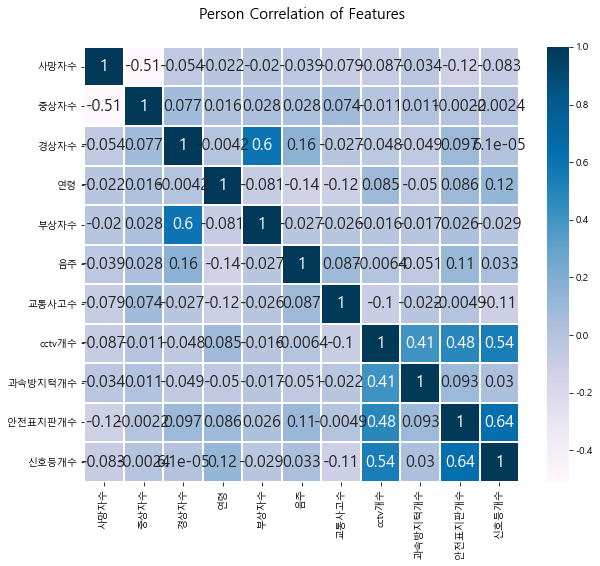



로지스틱 회귀 모델 결과 유의미한 영향의 끼치는 요소는 다음과 같습니다.


    >>>> 유의미한 요소에 대한 부분 회귀 결과 <<<<



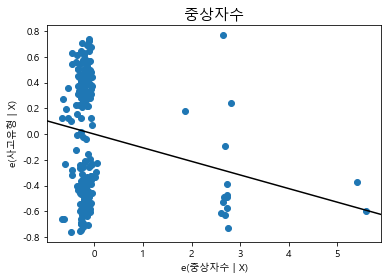

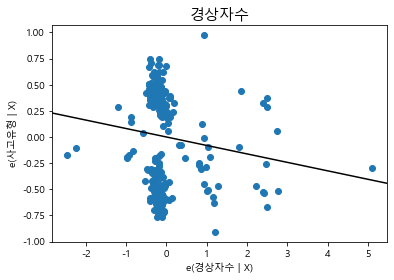

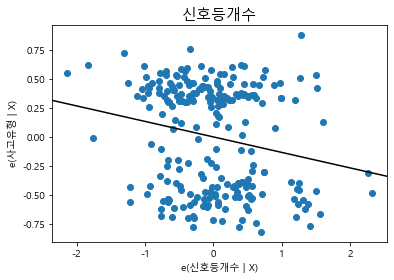

유형에는 차대사람-기타, 차대차-기타, 측면직각충돌, 보도통행중, 추돌(진행중), 정면충돌, 차도통행중, 차량단독-기타, 횡단중, 기타가 있습니다.

원하는 유형을 입력하세요(공백입력시 종료) : 


In [ ]:
#사용자가 원하는 사고 유형에 대한 원인 분석
while True:
    print("유형에는 차대사람-기타, 차대차-기타, 측면직각충돌, 보도통행중, 추돌(진행중), 정면충돌, 차도통행중, 차량단독-기타, 횡단중, 기타가 있습니다.\n")
    type = input("원하는 유형을 입력하세요(공백입력시 종료) : ")
    if(type==""):
        break
    model(type)
    
